# Active Learning

Showcase of active learning in bofire. Active learning per definition focusses on fitting the model to the experimental observations best possible in an iterative manner. The ActiveLearningStrategy proposes a set of evaluation points that will gain the most information about the problem each iteration. Thus, an unknown black-box-function can be approximated without optimization. It represents an exploration-only strategy. 

In [19]:
from bofire.data_models.strategies.api import RandomStrategy
import pandas as pd
from bofire.runners.api import run
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from bofire.benchmarks.api import GenericBenchmark
import multiprocessing

import bofire.strategies.api as strategies
from bofire.data_models.api import Domain, Outputs, Inputs
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.objectives.api import MinimizeObjective
from bofire.benchmarks.single import Himmelblau, Ackley
import os

SMOKE_TEST = os.environ.get("SMOKE_TEST")

### 1-D Objective Function

For a 1-D objective function. The Himmelblau benchmark is used.
\begin{equation}
    f: \mathbb{R}^2 \rightarrow \mathbb{R} \quad | \quad f(x_1, x_2) = (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2) ^2
\end{equation}
To start the active learning strategy we need to supply some initial data points to set up the Gaussian Regression Model in the background.

In [20]:
himmelblau = Himmelblau()
def sample(domain: Domain):
    datamodel = RandomStrategy(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

initial_points = sample(domain=himmelblau.domain)
initial_experiments = pd.concat([initial_points, himmelblau.f(initial_points)], axis=1)
display(initial_experiments)

,x_1,x_2,y,valid_y
0,-3.720625,-2.139677,38.223879,1
1,1.116535,-1.941434,141.238207,1
2,1.747025,1.237972,58.864584,1
3,-5.102151,0.472605,381.496910,1
4,1.073421,-4.552555,426.384802,1
5,-1.028356,-1.206774,167.497817,1
6,1.843022,-5.345912,716.261849,1
7,2.344156,1.074057,31.898392,1
8,-5.771299,1.705104,673.920826,1
9,-2.940415,-2.870591,30.186374,1


#### ActiveLearningStrategy

The `ActiveLearningstrategy` can be set up just as other BO strategies implemented in bofire. Just take a look into the other tutorials. Basic calls are `ask()` to retrieve new evaluation candidates from the acquisition function and `tell()` to train the model with a new observation.

Currently, the default active learning acqusition function implemented is `qNegIntegratedPosteriorVariance`. It focuses on minimzing the overall posterior variance by choosing a new candidate.

The `ActiveLearningStrategy` uses Monte-Carlo-integration to evaluate the acquisition function. The number of integration nodes significantly influences the speed of the integration. These can be adjusted by changing the paramater `data_model.num_sobol_samples`. Note that a sample size representing a power of $2$ increases performance.

In [21]:
# Manual set up of ActiveLearning
from bofire.data_models.strategies.api import ActiveLearningStrategy
from bofire.data_models.surrogates.api import BotorchSurrogates, SingleTaskGPSurrogate

data_model = ActiveLearningStrategy(
    domain=himmelblau.domain,
    surrogate_specs=BotorchSurrogates(
        surrogates=[
            SingleTaskGPSurrogate(
                inputs=himmelblau.domain.inputs,
                outputs=himmelblau.domain.outputs,
            ),
        ]
    ),
)
recommender = strategies.map(data_model=data_model)
recommender.tell(experiments=initial_experiments)
candidates = recommender.ask(candidate_count=1)
display(candidates)

,x_1,x_2,y_pred,y_sd,y_des
0,0.297437,4.419262,386.212616,311.108372,-386.212616


In [22]:
# Running the active learning strategy
max_iter = 20
results = initial_experiments

for iter in range(max_iter):
    # run active learning strategy
    X = recommender.ask(candidate_count=1)[himmelblau.domain.inputs.get_keys()]
    Y = himmelblau.f(X)
    XY = pd.concat([X, Y], axis=1)
    recommender.tell(experiments=XY)  # pass new experimental data
    results = pd.concat([results, XY], axis=0, ignore_index=True)

In [23]:
# Running a random strategy for comparison
def strategy_factory(domain: Domain):
    data_model = RandomStrategy(domain=domain)
    return strategies.map(data_model)

random_results = run(
    himmelblau,
    strategy_factory=strategy_factory,
    n_iterations=max_iter if not SMOKE_TEST else 1,
    metric=lambda domain, experiments: 1.0,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 1.000: 100%|██████████| 20/20 [00:00<00:00, 177.37it/s]


#### Plotting

Text(0.5, 1.0, 'active learning strategy')

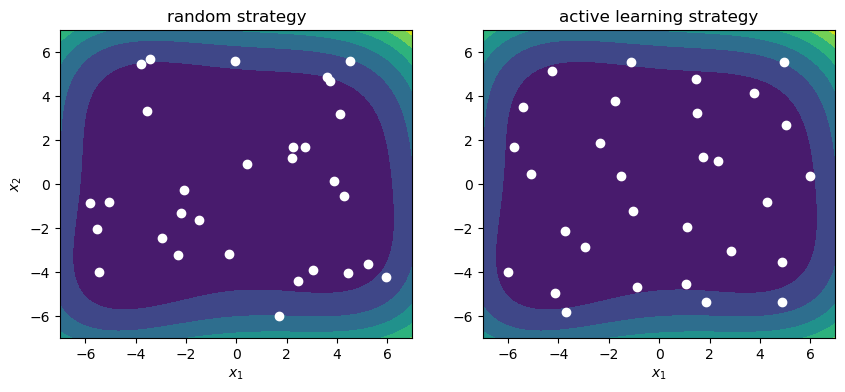

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)

fig, ax = plt.subplots(1,2)
# contour plot of himmelblau
def f(grid):
    return (grid[0]**2 + grid[1] - 11)**2 + (grid[0] + grid[1]**2)**2
X_grid = np.arange(-7, 7, 0.01)
Y_grid = np.arange(-7, 7, 0.01)
mesh = np.meshgrid(X_grid, Y_grid)
Z = f(grid=mesh)
levels = np.linspace(Z.min(), Z.max(), 6)


ax[0].contourf(
    X_grid, Y_grid, Z, cmap=cm.viridis
)
ax[0].scatter(random_results[0][0].x_1, random_results[0][0].x_2, c="white")
ax[1].contourf(
    X_grid, Y_grid, Z, cmap=cm.viridis
)
ax[1].scatter(results.x_1, results.x_2, c="white")

ax[0].axis([-7, 7, -7, 7])
ax[0].set_xlabel("$x_1$")
ax[1].set_xlabel("$x_1$")
ax[0].set_ylabel("$x_2$")
ax[0].set_title("random strategy")
ax[1].set_title("active learning strategy")

The plot shows the exploratory behavior of the `ActiveLearningStrategy`.

### 2-D (n-D) Objective Function

Now, we want to actively learn an objective function with a multi-dimensional output space. This is shown by an example function with $2$ output variables. For this, we again utilize the Himmelblau benchmark function and the Ackley function.

\begin{equation}
    \bm{f}: \mathbb{R}^2 \rightarrow \mathbb{R}^2   \quad | \quad 
    \bm{f}(x_1, x_2) = 
        \begin{pmatrix}
            (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2) ^2 \\
            -20\exp \left[-0.2{\sqrt {0.5\left(x_1^{2}+x_2^{2}\right)}}\right]
            -\exp \left[0.5\left(\cos 2\pi x_1+\cos 2\pi x_2\right)\right]+e+20

        \end{pmatrix}
\end{equation}

In [25]:
from bofire.benchmarks.single import Ackley
from bofire.benchmarks.benchmark import GenericBenchmark

inputs = Inputs(
    features=[
        ContinuousInput(key="x_1", bounds=(-6, 6)),
        ContinuousInput(key="x_2", bounds=(-6, 6)),
    ]
)
outputs = Outputs(
    features=[
        ContinuousOutput(key="f_0", objective=MinimizeObjective()),
        ContinuousOutput(key="f_1", objective=MinimizeObjective()),
    ]
)
domain = Domain(
    inputs=inputs, outputs=outputs
)
def benchmark_function(candidates):
    f0 = (candidates["x_1"] ** 2 + candidates["x_2"] - 11) ** 2 + (
        candidates["x_1"] + candidates["x_2"] ** 2
    ) ** 2
    f1 = -20 * np.exp(-0.2*np.sqrt(0.5*(candidates["x_1"]**2 + candidates["x_2"]**2)))
    - np.exp(0.5*(np.cos(2*np.pi*candidates["x_1"]) + np.cos(2*np.pi*candidates["x_2"]))) + np.exp(1) + 20
    return pd.DataFrame({"f_0": f0, "f_1": f1})


function = GenericBenchmark(domain=domain, func=benchmark_function)
initial_experiments = pd.concat([initial_points, function.f(candidates=initial_points)], axis=1)

For the multi-objective function we need to pass two models to the strategy as each individual output is represented by a separate model.
By default, the `ActiveLearningStrategy` focusses on minimizing the negative integrated posterior variance of each model equally. To minimize the variances in a more specific way certain weights can be provided for each output feature. This can be done by passing a `dictionary` containing the individual weights for each output feature with its corresponding key to the parameter `weights`.

In [26]:
# Manual set up of ActiveLearning
weights = {
    "f_0": 0.4,
    "f_1": 0.6,
}
# create an instance of the aquisition function with distinct weights
from bofire.data_models.acquisition_functions.api import qNegIntPosVar
af = qNegIntPosVar(
    weights=weights
)

data_model = ActiveLearningStrategy(
    domain=domain,
    surrogate_specs=BotorchSurrogates(
        surrogates=[
            SingleTaskGPSurrogate(
                inputs=domain.inputs,
                outputs=Outputs(features=[domain.outputs[0]]),
            ),
            SingleTaskGPSurrogate(
                inputs=domain.inputs,
                outputs=Outputs(features=[domain.outputs[1]]),
            ),
        ]
    ),
    acquisition_function=af
)
recommender = strategies.map(data_model=data_model)
recommender.tell(experiments=initial_experiments)
candidates = recommender.ask(candidate_count=1)
display(candidates)

,x_1,x_2,f_0_pred,f_1_pred,f_0_sd,f_1_sd,f_0_des,f_1_des
0,0.490484,4.789869,488.1025,-12.96983,434.603445,2.302933,-488.1025,12.96983


In [27]:
# Running the active learning strategy
max_iter = 20
results = initial_experiments

for iter in range(max_iter):
    # run active learning strategy
    X = recommender.ask(candidate_count=1)[domain.inputs.get_keys()]
    Y = function.f(candidates=X)
    XY = pd.concat([X, Y], axis=1)
    recommender.tell(experiments=XY)  # pass new experimental data
    results = pd.concat([results, XY], axis=0, ignore_index=True)

In [28]:
random_results = run(
    function,
    strategy_factory=strategy_factory,
    n_iterations=max_iter if not SMOKE_TEST else 1,
    metric=lambda domain, experiments: 1.0,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 1.000: 100%|██████████| 20/20 [00:00<00:00, 190.66it/s]


#### Plotting

Text(0.5, 1.0, 'active learning strategy')

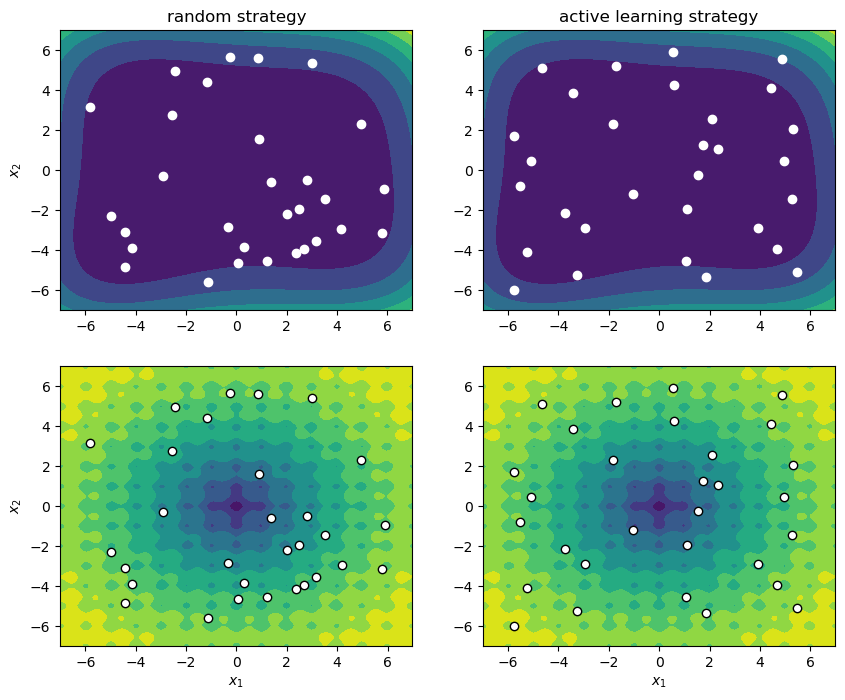

In [29]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax = plt.subplots(2,2)
def f1(grid):
    return -20 * np.exp(-0.2*np.sqrt(0.5*(grid[0]**2 + grid[1]**2))) - np.exp(0.5*(np.cos(2*np.pi*grid[0]) + np.cos(2*np.pi*grid[1]))) + np.exp(1) + 20
Z1 = f1(mesh)
levels = np.linspace(Z1.min(), Z1.max(), 10)
ax[0, 0].contourf(
    X_grid, Y_grid, Z, cmap=cm.viridis,
)
ax[0, 0].scatter(random_results[0][0].x_1, random_results[0][0].x_2, c="white")
ax[0, 1].contourf(
    X_grid, Y_grid, Z, cmap=cm.viridis,
)
ax[0, 1].scatter(results.x_1, results.x_2, c="white")
ax[1, 0].contourf(
    X_grid, Y_grid, Z1, cmap=cm.viridis, levels=levels
)
ax[1, 0].scatter(random_results[0][0].x_1, random_results[0][0].x_2, c="white", edgecolors='black')
ax[1, 1].contourf(
    X_grid, Y_grid, Z1, cmap=cm.viridis, levels=levels
)
ax[1, 1].scatter(results.x_1, results.x_2, c="white", edgecolors='black')

ax[0, 0].axis([-7, 7, -7, 7])
ax[1, 0].set_xlabel("$x_1$")
ax[1, 1].set_xlabel("$x_1$")
ax[0, 0].set_ylabel("$x_2$")
ax[1, 0].set_ylabel("$x_2$")
ax[0, 0].set_title("random strategy")
ax[0, 1].set_title("active learning strategy")